In [1]:
import numpy as np
import time
import random
import matplotlib.pyplot as plt

In [2]:
def plot(x,y,x_label,y_label,title):
    fig, ax = plt.subplots()
    ax.plot(x,y, label=y_label)#, linestyle = "", marker = "."
    ax.legend()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.axis('equal')
    plt.show()
def multiPlot(x,ys,x_label,y_label,title):
    fig, ax = plt.subplots()
    for k in range(len(ys)):
        ax.plot(x,ys[k][0], label= ys[k][1])
    ax.legend()
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.show()

In [3]:
def pseudoStep(a,b,c,e,x):
    return(a+(b-a)*(np.arctan((x-c)*e)/np.pi + 1/2)) # The higher is e, the greater is the slop
def smooth_indicator(x, a, b):
    e = 10/(b-a)
    left = pseudoStep(0,1,a, e,x)
    right = pseudoStep(1,0,b, e,x)
    return (left+right-1)*100
def game_stage(value):
    #100 =>0
    #mid game tipping point : 90
    #end game tipping point : 60
    #king_pawn tipping point : 42
    # prediction : probability of being at opening, mid, end, king-pawn
    prediction = np.array([smooth_indicator(value,90, 100),smooth_indicator(value,60, 90),smooth_indicator(value,42, 60),smooth_indicator(value,0, 42)])
    norm = np.sum(prediction)
    prediction = 100*prediction/norm
    prediction = [int(p) / 100 for p in prediction]
    return(prediction)

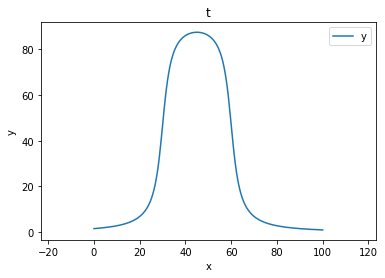

In [4]:
x = np.linspace(0,100,200)

plot(x,smooth_indicator(x,30, 60), "x", "y", "t")

In [5]:
def growing(children, side):
    grouped = group_with_relatives(children, len(children[0][1])-2)
    children_dict = {}
    for k in range(len(grouped)):
        if side:
            v = min(grouped[k], key=lambda x: x[2])[2]
        else:
            v = max(grouped[k], key=lambda x: x[2])[2]
        boards = [l[0] for l in grouped[k]]
        position = grouped[k][0][1][:-1]
        grouped[k] = [[],position , v, 1]
        children_dict[str(position)] = boards
    return(grouped, children_dict)
def sort_hunters(groups, depth, side):
    if depth < 0:
        return(groups)
    else:
        for k in range(len(groups)):
            groups[k] = [0, groups[k][0][1], groups[k]]
        groups = group_with_relatives(groups, depth)
        #groups = [family,family,...]
        #family = [[0, position, sorted_list], [0, position, sorted_list],[0, position, sorted_list]...]
        #sorted_list = [[board, position, score...], [board, position, score...], [board, position, score...]]
        for k in range(len(groups)): #pour chaque famille
            family = groups[k]
            new = []
            ind = 0 #On commence par prendre le meilleur
            p = True
            while p:
                l = []
                for i in range(len(family)): 
                    if ind < len(family[i][2]):
                        l.append(family[i][2][ind])
                if l!=[]:
                    l.sort(key=lambda l: l[2], reverse=side)
                    new +=l
                    ind += 1
                else:   
                    p = False   
            groups[k] = new
        return(sort_hunters(groups, depth -1, side==False))
def score_hunters(hunters, tree_depth, parameters):
    contrast = parameters.contrast[tree_depth]
    deplete_rate = parameters.deplete_rate[tree_depth]
    width  = parameters.width[tree_depth]
    l = len(hunters)
    if l==0:
        return([])
    elif l ==1:
        hunters[0][3] = width
        return(hunters)
    elif l==2:
        rate = 1/contrast
    else:    
        rate = 1/contrast**(1/(l-1))
    weights = [rate ** (i**deplete_rate*(l-1)**(1-deplete_rate)) for i in range(l)]
    print("rate = " + str(rate))
    print(weights)
    norm = width/sum(weights)
    for k in range(l):
        hunters[k][3] = norm*weights[k]
    return(hunters)
def hunt(hunters, tree_depth, parameters, side): 
    #tree_depth = i+3 = len(position)
    for k in range(len(hunters)):
        hunters[k] = [hunters[k]]
    sorted_hunters = sort_hunters(hunters, tree_depth-1, side)[0]
    scored_hunters = score_hunters(sorted_hunters, tree_depth, parameters) 
    approxed_hunters = approx(scored_hunters)
    a = [e[3] for e in approxed_hunters if e[3]>0.3]
    print(a)
    print(sum(a))
    return(approxed_hunters)

def approx(hunters):
    keep = []
    for k in range(len(hunters)):
        f = hunters[k][3]
        if f <3:
            f = 3*np.random.binomial(1,int(f*100)/300)
        else:
            i = np.floor(f)
            p = int((f-i)*100)/300
            f = i + 3*np.random.binomial(1,p)
        if f>=2:
            hunters[k][3] = int(f)
            keep.append(k)
    hunters = [hunters[i] for i in keep] 
    return(hunters)
def reasign(children, dict_children):
    for k in range(len(children)):
        children[k][0] = dict_children[str(children[k][1])]
    return(children)
def group_with_relatives(L, depth):
    result = {}
    for l in L:
        prefix = l[1][:depth+1]
        if str(prefix) in result:
            result[str(prefix)].append(l)
        else:
            result[str(prefix)] = [l]
    return (list(result.values()))
def gen_N(n, n_):
    q = n//n_
    r = n%n_
    random_integers = random.sample(range(n_), r)
    N = [q]*n_
    for i in range(r):
        N[random_integers[i]] +=1
    return(N)
def select(children, side, I, parameters):
    survived = []
    killed = 0
    print("len(children) =" + str(len(children)))
    for k in range(len(children)):
        n = children[k][3]
        n_ = len(children[k][0])
        N = gen_N(n, n_)
        for j in range(n_):
            print("k = " + str(k))
            print("j = " + str(j))
            print("len(children) =" + str(len(children)))
            print(children)
            c = children[k]
            print(c)
            print(c[0])
            s, kill = keep(c[0][j], N[j], I, parameters, side)    
            survived += s
            killed +=kill
    print("survived: " + str(len(survived)))
    print("killed: " + str(killed))
    return(survived)
def keep(L, n, I, parameters, side):
    depth = len(L[0][1])
    if len(L)<= n:
        return L, 0
    else:
        L.sort(key=lambda l: l[2], reverse=side)
        w2 = int(np.ceil((1-parameters.risk[depth])*n))
        
        p = L[:w2]
        rest = L[w2:]
        l = len(rest)
        if l <=1:
            return L[:n], len(L)-n
        rate = 1/parameters.contrast[depth]**(1/(l-1))
        weights = [rate ** i for i in range(l)]
        s = unique(random.choices(rest, weights, k=n - w2))
        survived = p + s
        return survived, len(L)-len(survived)

In [6]:
#parameters
class Parameters:
    def __init__(self, depth, width, risk, contrast, deplete_rate, agressivity):
        self.depth = depth
        self.width = width
        self.risk = risk
        self.contrast = contrast
        self.deplete_rate = deplete_rate
        self.agressivity = agressivity
    def random_modify(self):
        self.width = [w * random.uniform(0.9, 1.1) for w in self.width]
        self.risk = [r * random.uniform(0.9, 1.1) for r in self.risk]
        self.contrast = [c * random.uniform(0.9, 1.1) for c in self.contrast]
        self.aggressivity *= random.uniform(0.9, 1.1)

In [7]:
tree0 = [[[0],[0], 0, 0]]
tree1 = [[[0],[0,0], 1, 0], [[0],[0,1], 2, 0]]
tree2 = [[[0],[0,0,0], 3, 0], [[0],[0,0,1], 4, 0], [[0],[0,1,0], 5, 0], [[0],[0,1,1], 6, 0]]
tree3 = [[[0],[0,0,0,0], 10, 10], [[0],[0,0,0,1], 7, 7], [[0],[0,0,1,0], 9, 9], [[0],[0,0,1,1], 8, 8], [[0],[0,1,0,0], -10, -10], [[0],[0,1,0,1], -1, -1], [[0],[0,1,1,0], 0, 0], [[0],[0,1,1,1], -4, -4]]
tree4 = [[[0],[0,0,0,0,0], 4, 4], [[0],[0,0,0,1,0], -1, -1], [[0],[0,0,1,0,0], -1, -1], [[0],[0,0,1,1,0], 5, 5], [[0],[0,1,0,0,0], 3, 3], [[0],[0,1,0,1,0], 0, 0], [[0],[0,1,1,0,0], -2, -2], [[0],[0,1,1,1,0], 8, 8], [[0],[0,0,0,0,1], 7, 7], [[0],[0,0,0,1,1], 0, 0], [[0],[0,0,1,0,1], 1, 1], [[0],[0,0,1,1,1], -2, -2], [[0],[0,1,0,0,1], -2, -2], [[0],[0,1,0,1,1], 4, 4], [[0],[0,1,1,0,1], -5, -5], [[0],[0,1,1,1,1], 9, 9]]
tree = [tree0, tree1, tree2, tree3, tree4]

depth = 4
#max depth = depth + 3  
width = [1, "?", "?", 4, 300, 400, 350]
risk = ["?","?","?",0.3,0.25,0.25, 0.2] # risk[0] selection pour les enfants de la racine
contrast = ["?","?","?",4,50,30,20] #contrast[1] contraste pour la sélection et distribution de ressource pour la couche 1 
deplete_rate = ["?","?","?",0.4,0.4,0.5,0.6]
agressivity = 0.5
parameters = Parameters(depth, width, risk, contrast, deplete_rate, agressivity)

print("reproducing")
children1 = [[[[0],[0,0,0,0], 10, 10], [[0],[0,0,0,1], 7, 7]], [0,0,0], 7]
children2 = [[[[0],[0,0,1,0], 9, 9], [[0],[0,0,1,1], 8, 8]], [0,0,1], 8]
children3 = [[[[0],[0,1,0,0], -10, -10], [[0],[0,1,0,1], -1, -1]],[0,1,0] ,-10]
children4 = [[[[0],[0,1,1,0], 0, 0], [[0],[0,1,1,1], -4, -4]], [0,1,1], -4]
children = [children1,children2,children3,children4]
print("growing")
hunters, dict_ = growing(children, False)
print("hunting")
hunters = hunt(hunters, 3, parameters, False)
print("before")
print(hunters)
hunters = reasign(hunters, dict_)
print("after")
print(hunters)
survived = select(hunters, False, 0, parameters)
print(survived)

reproducing
growing
hunting
rate = 0.25
[1.0, 0.25]
[3, 3]
6
before
[[[], [0, 1], -4, 3], [[], [0, 0], 8, 3]]
after
[[[[[[0], [0, 1, 0, 0], -10, -10], [[0], [0, 1, 0, 1], -1, -1]], [[[0], [0, 1, 1, 0], 0, 0], [[0], [0, 1, 1, 1], -4, -4]]], [0, 1], -4, 3], [[[[[0], [0, 0, 0, 0], 10, 10], [[0], [0, 0, 0, 1], 7, 7]], [[[0], [0, 0, 1, 0], 9, 9], [[0], [0, 0, 1, 1], 8, 8]]], [0, 0], 8, 3]]
len(children) =2
k = 0
j = 0
len(children) =2
[[[[[[0], [0, 1, 0, 0], -10, -10], [[0], [0, 1, 0, 1], -1, -1]], [[[0], [0, 1, 1, 0], 0, 0], [[0], [0, 1, 1, 1], -4, -4]]], [0, 1], -4, 3], [[[[[0], [0, 0, 0, 0], 10, 10], [[0], [0, 0, 0, 1], 7, 7]], [[[0], [0, 0, 1, 0], 9, 9], [[0], [0, 0, 1, 1], 8, 8]]], [0, 0], 8, 3]]
[[[[[0], [0, 1, 0, 0], -10, -10], [[0], [0, 1, 0, 1], -1, -1]], [[[0], [0, 1, 1, 0], 0, 0], [[0], [0, 1, 1, 1], -4, -4]]], [0, 1], -4, 3]
[[[[0], [0, 1, 0, 0], -10, -10], [[0], [0, 1, 0, 1], -1, -1]], [[[0], [0, 1, 1, 0], 0, 0], [[0], [0, 1, 1, 1], -4, -4]]]
k = 0
j = 1
len(children) =2
[[[[[[

In [36]:
a =0
N = int(10**7)
start_time = time.time()
for k in range(N):
    a+=1
print("time used:", (time.time()-start_time)/N, "seconds")

time used: 7.380011081695556e-08 seconds
